In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import os
import ast
import torch
import pickle
import keyboard
import numpy as np
import pandas as pd
from utils.env_utils import *
from utils.eval_utils import *
import matplotlib.pyplot as plt
from utils.train_utils import *
from utils.couzin_utils import *
from marl_aquarium import aquarium_v0
from models.Buffer import Pool, Buffer

## Model Comparison using Swarm Metrics

In [2]:
num_steps = 100

model_folder = rf"..\models\trained_policies"
data_path = rf'..\data\processed\pred_prey_interactions\expert_tensors\33'
ftw_path = rf"..\data\processed\pred_prey_interactions\full_track_windows\33"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)

env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
print("Environment initialized")

Environment initialized


In [5]:
# GAIL Simulation
gail_pred_policy = torch.load(os.path.join(model_folder, "bc_pred_policy.pt"), weights_only=False)
gail_prey_policy = torch.load(os.path.join(model_folder, "bc_prey_policy.pt"), weights_only=False)
gail_metrics = run_policies_in_steps(env, gail_pred_policy, gail_prey_policy, steps=num_steps, render=False)
print("GAIL Simulation done!")

# BC Simulation
bc_pred_policy = torch.load(os.path.join(model_folder, "bc_pred_policy.pt"), weights_only=False)
bc_prey_policy = torch.load(os.path.join(model_folder, "bc_prey_policy.pt"), weights_only=False)
bc_metrics = run_policies_in_steps(env, bc_pred_policy, bc_prey_policy, steps=num_steps, render=False)
print("BC Simulation done!")

# Couzin Simulation
pred_tensor, prey_tensor, pred_log, prey_log = run_couzin_simulation(visualization="off", max_steps=num_steps)
print("Couzin Simulation done!")

# Load Expert Data
expert_buffer = Buffer(pred_max_length=23000, prey_max_length=700000, device=device)
expert_buffer.add_expert(data_path)
len_exp_pred, len_exp_prey = expert_buffer.lengths()
print(f"Expert Trajectories loaded - Pred: {len_exp_pred}, Prey: {len_exp_prey}")

GAIL Simulation done!
BC Simulation done!
Couzin Simulation done!
Expert Trajectories loaded - Pred: 21420, Prey: 685440


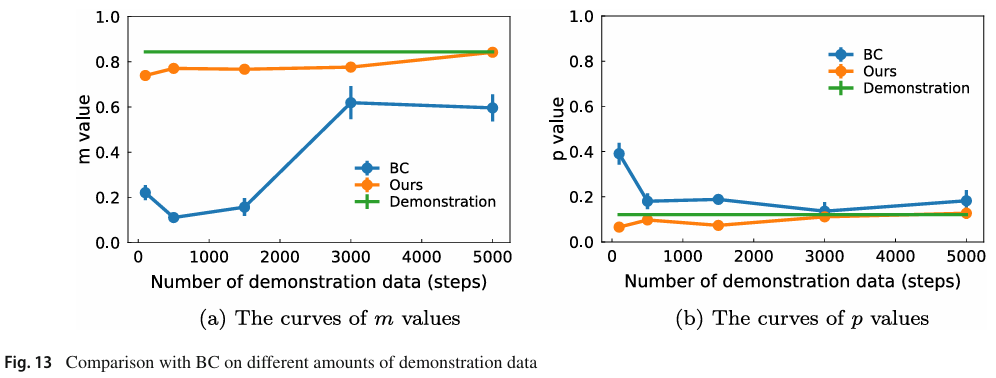

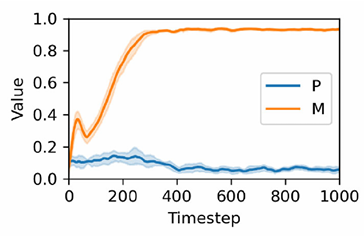

In [ ]:
''' 
Metrics:
Swarm Specific (Wu et al):
- Polarization
- Angular Momentum
- Degree of sparsity

Predator-Prey Specific
- Mean Distance to Predator
- Escape Alignment
'''

In [ ]:
def plot_swarm_metrics(gail_metrics, bc_metrics, couzin_metrics, expert_buffer, time_steps=[0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]):
    gail_x, gail_y, gail_vx, gail_vy = gail_metrics


    gail_polarization, gail_sparsity, gail_angular_momentum = [], [], []
    bc_polarization, bc_sparsity, bc_angular_momentum = [], [], []
    couzin_polarization, couzin_sparsity, couzin_angular_momentum = [], [], []

## Analysis of Modular Networks

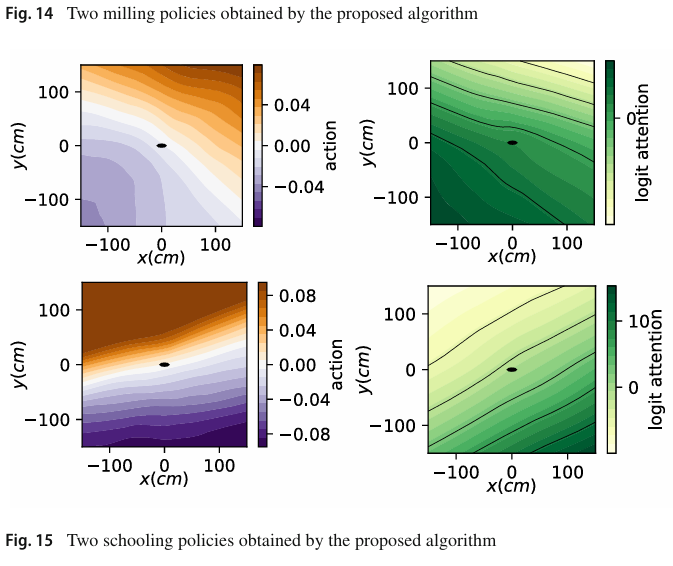

In [3]:
model_folder = rf"..\models\trained_policies"
gail_pred_policy = torch.load(os.path.join(model_folder, "bc_pred_policy.pt"), weights_only=False)
gail_prey_policy = torch.load(os.path.join(model_folder, "bc_prey_policy.pt"), weights_only=False)

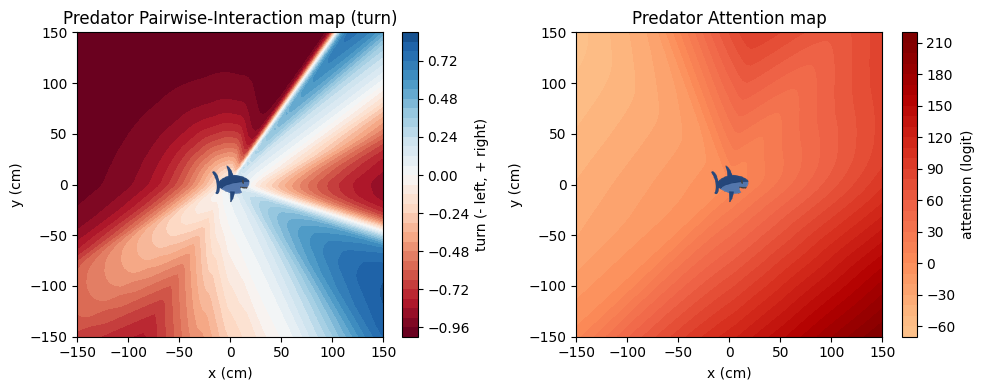

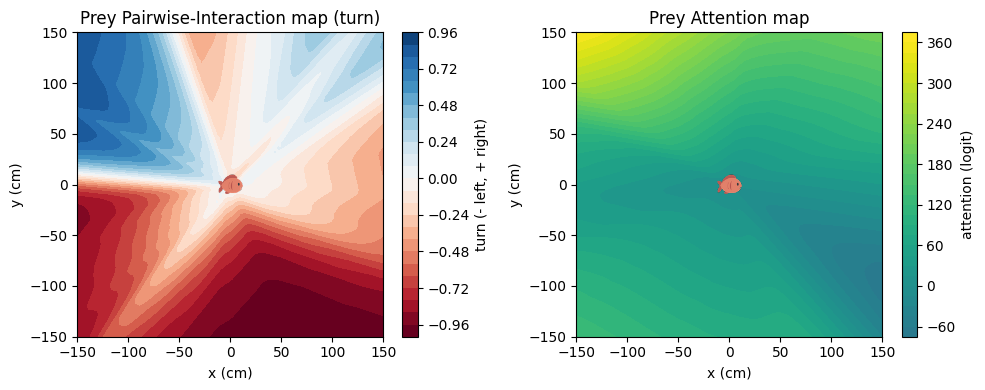

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# -------------------------------------------------
# Pairwise-Action & Attention Maps
# -------------------------------------------------
def compute_pairwise_and_attention_maps(pairwise_net,
                                        attn_net,
                                        role,                 # "predator" oder "prey"
                                        v=1.0,
                                        x_range=(-150, 150),
                                        y_range=(-150, 150),
                                        n_points=80,
                                        n_orient=72,
                                        device="cpu"):

    pairwise_net.to(device).eval()
    attn_net.to(device).eval()

    xs = np.linspace(*x_range, n_points)
    ys = np.linspace(*y_range, n_points)

    thetas = torch.linspace(0.0, 2*np.pi, n_orient + 1, device=device)[:-1]
    vx = v * torch.cos(thetas)
    vy = v * torch.sin(thetas)

    action_map = np.zeros((n_points, n_points), dtype=np.float32)
    attn_map   = np.zeros((n_points, n_points), dtype=np.float32)

    with torch.no_grad():
        for ix, x in enumerate(xs):
            for iy, y in enumerate(ys):
                if abs(x) < 1e-6 and abs(y) < 1e-6:
                    action_map[iy, ix] = np.nan
                    attn_map[iy, ix] = np.nan
                    continue

                rel_x = torch.full((n_orient, 1), float(x), device=device)
                rel_y = torch.full((n_orient, 1), float(y), device=device)
                inputs = torch.cat([rel_x, rel_y, vx.unsqueeze(1), vy.unsqueeze(1)], dim=1)

                # ---- PairwiseInteraction -> Aktion ----
                mu, sigma = pairwise_net(inputs)
                turn = torch.tanh(mu.squeeze())   # [-1, 1]
                action_map[iy, ix] = turn.mean().item()

                # ---- Attention -> Gewicht (Logits) ----
                w_logits = attn_net(states=inputs, pred_states=inputs, role=role)

                # Falls das Netz ein Tuple (z.B. (w_prey, w_pred)) zurückgibt:
                if isinstance(w_logits, tuple):
                    w_logits = w_logits[0]   # ersten Output nehmen (typischerweise w_prey)

                w_logits = w_logits.squeeze()
                attn_map[iy, ix] = w_logits.mean().item()

    return xs, ys, action_map, attn_map


# -------------------------------------------------
# Plot
# -------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_policy_maps(xs, ys, action_map, attn_map, title_prefix="", img_path=None):

    # Turn-Map: immer diverging (links/rechts)
    cmap_action = "RdBu"
    # Attention: Predator rötlicher, Prey wie gehabt
    cmap_attn = "OrRd" if title_prefix.lower() == "predator" else "viridis"

    X, Y = np.meshgrid(xs, ys)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ---------- Pairwise Interaction (turn) ----------
    vmax_act = np.nanmax(np.abs(action_map))
    norm_act = colors.TwoSlopeNorm(vcenter=0, vmin=-vmax_act, vmax=vmax_act)

    im0 = axes[0].contourf(X, Y, action_map,
                           levels=30,
                           cmap=cmap_action,
                           norm=norm_act)
    axes[0].set_title(f"{title_prefix} Pairwise-Interaction map (turn)")
    axes[0].set_xlabel("x (cm)")
    axes[0].set_ylabel("y (cm)")
    plt.colorbar(im0, ax=axes[0], label="turn (- left, + right)")

    # ---------- Attention Map (logits, 0 zentriert) ----------
    vmax_att = np.nanmax(np.abs(attn_map))
    norm_att = colors.TwoSlopeNorm(vcenter=0, vmin=-vmax_att, vmax=vmax_att)

    im1 = axes[1].contourf(X, Y, attn_map,
                           levels=30,
                           cmap=cmap_attn,
                           norm=norm_att)
    axes[1].set_title(f"{title_prefix} Attention map")
    axes[1].set_xlabel("x (cm)")
    axes[1].set_ylabel("y (cm)")
    plt.colorbar(im1, ax=axes[1], label="attention (logit)")

    # ---------- Achsenbereich fixieren (+/- Maximalwert aus xs/ys) ----------
    x_range = (xs.min(), xs.max())
    y_range = (ys.min(), ys.max())

    for ax in axes:
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)

    # ---------- Icon in der Mitte ----------
    if img_path is not None:
        icon = mpimg.imread(img_path)
        imgbox = OffsetImage(icon, zoom=0.45)
        center = (0, 0)
        for ax in axes:
            ab = AnnotationBbox(imgbox, center, frameon=False, xycoords='data')
            ax.add_artist(ab)

    plt.tight_layout()
    plt.show()


# -------------------------------------------------
# Anwendung auf deine Policies
# -------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
pred_img_path = rf"..\data\predator.png"
prey_img_path = rf"..\data\prey.png"

# Predator
xs, ys, pred_action_map, pred_attn_map = compute_pairwise_and_attention_maps(
    pairwise_net=gail_pred_policy.pairwise,
    attn_net=gail_pred_policy.attention,
    role="predator",
    v=1.0,
    x_range=(-150, 150),
    y_range=(-150, 150),
    n_points=80,
    n_orient=72,
    device=device,
)
plot_policy_maps(xs, ys, pred_action_map, pred_attn_map, title_prefix="Predator", img_path=pred_img_path)

# Prey
xs, ys, prey_action_map, prey_attn_map = compute_pairwise_and_attention_maps(
    pairwise_net=gail_prey_policy.pairwise,
    attn_net=gail_prey_policy.attention,
    role="prey",
    v=1.0,
    x_range=(-150, 150),
    y_range=(-150, 150),
    n_points=80,
    n_orient=72,
    device=device,
)

plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, title_prefix="Prey", img_path=prey_img_path)
